In [20]:
import os
import warnings
warnings.simplefilter('ignore')

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model import make_fc

from greedy_coverage import set_func, marginal_vec, greedy
from greedy_submodular import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from continuous_coverage import optimize_coverage_multilinear, CoverageInstanceMultilinear, dgrad_coverage, hessian_coverage
from continuous_submodular import ContinuousOptimizer


Parameters

In [8]:
beta = 1
sample_size = 10
eps = 0.2
k = 10

num_epochs = 30
batch_size = 100
learning_rate = 1e-3

num_layers = 2
activation = 'relu'
intermediate_size = 200

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

In [9]:
N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 8
N_INSTANCES = 100 
N_TRAIN = int(0.8 * N_INSTANCES)

##### Instances definition

For each X,Y -> making X_train, X_test, Y_train, Y_test


In [4]:
path = "instances_weibo/"

def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        
        if instance in train_id :
            X_train[c_train] = np.load(path + f"X{instance}.npz")['arr_0']
            Y_train[c_train] = np.load(path + f"Y{instance}.npz")['arr_0']
            c_train += 1
        else : 
            X_test[c_test] = np.load(path + f"X{instance}.npz")['arr_0']
            Y_test[c_test] = np.load(path + f"Y{instance}.npz")['arr_0']
            c_test += 1
    
    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels 
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test

# train_id = list(range(N_INSTANCES))[:80]
# X_train, Y_train, X_test, Y_test = create_train_test(train_id)
w = np.ones(N_TARGETS, dtype=np.float32)


In [5]:
def normalize_train(X) :
    """
    The first 4 features are about influencers, which vary in dimension 1
    The last 4 are about targets, which vary in dimension 2
    
    """ 
    X[:,:,:,:4] = torch.nn.functional.normalize(X[:,:,:,:4], dim=1)
    X[:,:,:,4:] = torch.nn.functional.normalize(X[:,:,:,4:], dim=2)

    return X


train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id)
#X_train = normalize_train(X_train)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 


### Decision focused

In [30]:
%%time
train_scores = []
test_scores  = []
loss_f = []
net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

def eval_grd(net, X, Y):
    return np.mean([set_func(greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            true_set_func = partial(set_func, P = P, w = w)
            marginal_vec_pred = partial(marginal_vec, w = w)
            pred = net(X).view_as(P)                
            fn = GreedyOptimizer(true_set_func, marginal_vec_pred, n = N_INFLUENCERS, K = k, eps = eps, sample_size = sample_size, beta = beta)
            loss -= fn(pred)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_f.append(loss.item())
    
    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()

epoch | loss | train_score | test_score 
0 | -0.059670425951480865 | 0.00481007918715477 | 0.004397359490394592
1 | -0.05821054056286812 | 0.004611024260520935 | 0.00639667809009552
2 | -0.05672761797904968 | 0.004611024260520935 | 0.00405292809009552
3 | -0.05708125978708267 | 0.004673337191343307 | 0.00405292809009552
4 | -0.055170848965644836 | 0.004673337191343307 | 0.006912139058113098
5 | -0.061828866600990295 | 0.0047547690570354465 | 0.00639667809009552
6 | -0.06011433154344559 | 0.004673337191343307 | 0.00639667809009552
7 | -0.05709736421704292 | 0.004611024260520935 | 0.00639667809009552


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 80000000 bytes. Buy new RAM!


The model does not seem to learn anything. The loss does not decrease.

### 2 Stage

In [31]:
%%time 

train_scores = []
test_scores  = []
loss_2 = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
optfunc = partial(optimize_coverage_multilinear, w = w, k=k, c = 0.95)
dgrad = partial(dgrad_coverage, w = w)
hessian = partial(hessian_coverage, w = w)
opt = ContinuousOptimizer(optfunc, dgrad, hessian, 0.95)
opt.verbose = False

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            pred = net(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_2.append(loss.item())

    def eval_two_stage(net, X, Y):
        return np.mean([set_func(np.argsort(- opt(net(X[i]).view_as(Y_train[0])).detach().numpy())[:k], Y[i], w) for i in range(X.shape[0])])

    train_score = eval_two_stage(net, X_train, Y_train)
    test_score  = eval_two_stage(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()


epoch | loss | train_score | test_score 


KeyboardInterrupt: 

### CNT

In [25]:
%%time

train_scores = []
test_scores  = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

optfunc = partial(optimize_coverage_multilinear, w = w, k=k, c = 0.95)
dgrad = partial(dgrad_coverage, w = w)
hessian = partial(hessian_coverage, w = w)
opt = ContinuousOptimizer(optfunc, dgrad, hessian, 0.95)
opt.verbose = False
                
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            true_cnt_func = CoverageInstanceMultilinear(P, w, True)
            pred = net(X).view_as(P)
            x = opt(pred)
            loss -= true_cnt_func(x)
        loss = loss / batch_size
        print(f" loss :{loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def eval_cnt(net, X, Y):
        return np.mean([set_func(np.argsort(-opt(net(X[i]).view_as(Y_train[0])).detach().numpy())[:k], Y[i], w) for i in range(X.shape[0])])

    train_score = eval_cnt(net, X_train, Y_train)
    test_score  = eval_cnt(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()

Epoch 0
 loss :-0.06213214993476868
train_score : 0.06102807968854904
test_score : 0.08804971873760223
Epoch 1
 loss :-0.06167786568403244
train_score : 0.0636550635099411
test_score : 0.0738128662109375
Epoch 2
 loss :-0.058610666543245316
train_score : 0.05960375517606735
test_score : 0.04713515043258667
Epoch 3
 loss :-0.05928848311305046
train_score : 0.054165881127119064
test_score : 0.06885208487510681
Epoch 4
 loss :-0.05707332491874695
train_score : 0.050692237168550494
test_score : 0.07039657235145569
Epoch 5
 loss :-0.05721230059862137
train_score : 0.053242101520299914
test_score : 0.07202006578445434
Epoch 6
 loss :-0.05746745690703392
train_score : 0.053157521039247514
test_score : 0.07156298458576202
Epoch 7
 loss :-0.05741062015295029
train_score : 0.05717485025525093
test_score : 0.08369336128234864
Epoch 8
 loss :-0.05851224437355995
train_score : 0.0599472850561142
test_score : 0.08202738463878631
Epoch 9
 loss :-0.057411905378103256
train_score : 0.058214130252599715

<AxesSubplot:>

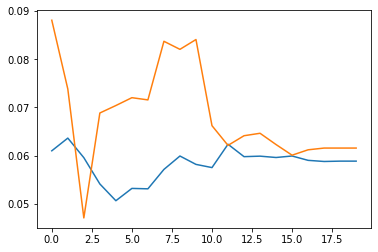

In [28]:
sns.lineplot(list(range(20)), train_scores)
sns.lineplot(list(range(20)), test_scores)